In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tfa-nightly

     |████████████████████████████████| 747kB 6.9MB/s 


In [ ]:
!pip install tensorflow-addons

In [ ]:
# Import Library
import tensorflow.keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D,MaxPooling2D
import tensorflow_addons as tfa
from tensorflow.keras.optimizers import RMSprop,SGD,Adam,Adadelta
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import os

In [ ]:
# Variable Definition
num_classes=7
height,width=48,48
batch_size=128

In [ ]:
!rm -rf fer2013
!mkdir fer2013
!mkdir fer2013/train
!mkdir fer2013/valid
!mkdir fer2013/test
! unzip -q '/content/drive/MyDrive/fer2013/train.zip' -d fer2013/train
! unzip -q '/content/drive/MyDrive/fer2013/test-public.zip' -d fer2013/valid
! unzip -q '/content/drive/MyDrive/fer2013/test-private.zip' -d fer2013/test

In [ ]:
# Dataset Directory
train_dir='fer2013/train'
validation_dir='fer2013/valid'
test_dir = 'fer2013/test'

In [ ]:
def smooth_labels(y, smooth_factor):
    '''Convert a matrix of one-hot row-vector labels into smoothed versions.
    https://www.dlology.com/blog/bag-of-tricks-for-image-classification-with-convolutional-neural-networks-in-keras/?fbclid=IwAR2RXBIUkuSdc21cQd3n8AG9CmGtC7MbVgEj3SFm-cfIDyHcexp7YjIhJKs

    # Arguments
        y: matrix of one-hot row-vector labels to be smoothed
        smooth_factor: label smoothing factor (between 0 and 1)

    # Returns
        A matrix of smoothed labels.
    '''
    assert len(y.shape) == 2
    if 0 <= smooth_factor <= 1:
        # label smoothing ref: https://www.robots.ox.ac.uk/~vgg/rg/papers/reinception.pdf
        y *= 1 - smooth_factor
        y += smooth_factor / y.shape[1]
    else:
        raise Exception(
            'Invalid label smoothing factor: ' + str(smooth_factor))
    return y

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    brightness_range = [0.8,1.2],
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=20,
    shear_range=0.1,
    zoom_range=0.1,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
def train_gen(train_datagen) :
  while True :
    x, y = next(train_datagen)
    y = smooth_labels(y, 0.1)
    yield x, y

In [ ]:
train_generator = train_datagen.flow_from_directory(
 train_dir,
 color_mode='rgb',
 target_size=(197,197),
 batch_size=batch_size,
 class_mode='categorical',
 shuffle=True)

validation_generator = validation_datagen.flow_from_directory(
 validation_dir,
 color_mode='rgb',
 target_size=(197,197),
 batch_size=batch_size,
 class_mode='categorical',
 shuffle=True)

test_generator = test_datagen.flow_from_directory(
 test_dir,
 color_mode='rgb',
 target_size=(197,197),
 batch_size=batch_size,
 class_mode='categorical',
 shuffle=True)

Found 28709 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.


In [ ]:
!sudo pip install git+https://github.com/rcmalli/keras-vggface.git
!pip install Keras-Applications

  Cloning https://github.com/rcmalli/keras-vggface.git to /tmp/pip-req-build-45bkqc__
  Running command git clone -q https://github.com/rcmalli/keras-vggface.git /tmp/pip-req-build-45bkqc__
  Created wheel for keras-vggface: filename=keras_vggface-0.6-cp36-none-any.whl size=8310 sha256=a5eff90804dd4b2018e3e79d7ccea308c3c324477daa4a93a4fa5384676b8d2f
  Stored in directory: /tmp/pip-ephem-wheel-cache-5qboupaq/wheels/36/07/46/06c25ce8e9cd396dabe151ea1d8a2bc28dafcb11321c1f3a6d
Successfully built keras-vggface
     |████████████████████████████████| 51kB 3.7MB/s 


In [ ]:
# continue train from check point
from keras_vggface.vggface import VGGFace
import tensorflow as tf

DROPOUT_RATE = 0.5
FROZEN_LAYER_NUM = 170

vgg_notop = VGGFace(model='resnet50', include_top=False, input_shape=(197, 197, 3), pooling='avg')
last_layer = vgg_notop.get_layer('avg_pool').output
x = Flatten(name='flatten')(last_layer)
x = Dropout(DROPOUT_RATE)(x)
x = Dense(4096, activation='relu', name='fc6')(x)
x = Dropout(DROPOUT_RATE)(x)
x = Dense(1024, activation='relu', name='fc7')(x)
x = Dropout(DROPOUT_RATE)(x)

batch_norm_indices = [2, 6, 9, 13, 14, 18, 21, 24, 28, 31, 34, 38, 41, 45, 46, 53, 56, 60, 63, 66, 70, 73, 76, 80, 83, 87, 88, 92, 95, 98, 102, 105, 108, 112, 115, 118, 122, 125, 128, 132, 135, 138, 142, 145, 149, 150, 154, 157, 160, 164, 167, 170]
for i in range(FROZEN_LAYER_NUM):
    if i not in batch_norm_indices:
        vgg_notop.layers[i].trainable = False

out = Dense(7, activation='softmax', name='classifier')(x)

model = tf.keras.Model(vgg_notop.input, out)


94699520/94694792 [==============================] - 3s 0us/step


In [ ]:
model.layers[170].name

'conv5_3_1x1_increase/bn'

In [ ]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 197, 197, 3) 0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 99, 99, 64)   9408        input_1[0][0]                    
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 99, 99, 64)   256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation (Activation)         (None, 99, 99, 64)   0           conv1/7x7_s2/bn[0][0]            
_______________________________________________________________________________________

In [ ]:
# Compile and Train
checkpoint = ModelCheckpoint('/content/drive/MyDrive/fer2013/Resnet50_8_12.h5',
                             monitor='val_accuracy',
                             mode='max',
                             save_best_only=True,
                             verbose=1)
earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=20,
                          verbose=1,
                          restore_best_weights=True
                          )
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',
                              factor=0.5,
                              mode = 'max',
                              patience=10,
                              verbose=1,
                              min_lr = 0.00001)
callbacks = [earlystop,checkpoint,reduce_lr]

In [ ]:
optimizer = tfa.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-4)
sgd = tf.keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=0.0001, nesterov=True)

In [ ]:
model.compile(loss='categorical_crossentropy',
 optimizer = sgd,
 metrics=['accuracy'])

nb_train_samples = 28709
nb_validation_samples = 3589
epochs=100

history=model.fit(
 train_gen(train_generator),
 steps_per_epoch=nb_train_samples//batch_size,
 epochs=epochs,
 callbacks=callbacks,
 validation_data=validation_generator,
 validation_steps=nb_validation_samples//batch_size)

Epoch 1/100
224/224 [==============================] - ETA: 0s - loss: 1.9420 - accuracy: 0.3155
Epoch 00001: val_accuracy improved from -inf to 0.16936, saving model to /content/drive/MyDrive/fer2013/Resnet50_8_12.h5
224/224 [==============================] - 345s 2s/step - loss: 1.9420 - accuracy: 0.3155 - val_loss: 1.8953 - val_accuracy: 0.1694
Epoch 2/100
224/224 [==============================] - ETA: 0s - loss: 1.5733 - accuracy: 0.4400
Epoch 00002: val_accuracy improved from 0.16936 to 0.18583, saving model to /content/drive/MyDrive/fer2013/Resnet50_8_12.h5
224/224 [==============================] - 339s 2s/step - loss: 1.5733 - accuracy: 0.4400 - val_loss: 1.8918 - val_accuracy: 0.1858
Epoch 3/100
224/224 [==============================] - ETA: 0s - loss: 1.4870 - accuracy: 0.4891
Epoch 00003: val_accuracy improved from 0.18583 to 0.42522, saving model to /content/drive/MyDrive/fer2013/Resnet50_8_12.h5
224/224 [==============================] - 338s 2s/step - loss: 1.4870 - acc

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


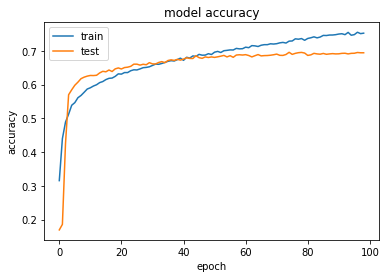

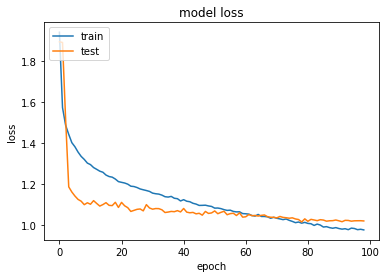

In [ ]:
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
import tensorflow as tf
model = tf.keras.models.load_model("/content/drive/MyDrive/huytung/Resnet50_8_12.h5")

In [ ]:
import tensorflow as tf
model = tf.keras.models.load_model("/content/drive/MyDrive/huytung/VGGFace16.h5")

In [ ]:
print('\n# Evaluate on test data')
results_test = model.evaluate_generator(test_generator, 3589 // batch_size)
print('test loss, test acc:', results_test)


# Evaluate on test data


InvalidArgumentError: ignored

In [ ]:
print('\n# Evaluate on test data')
results_test = model.evaluate_generator(validation_generator, 3589 // batch_size)
print('test loss, test acc:', results_test)